In [1]:
import pandas as pd
import torch

In [2]:
splits = {'train': 'train.csv', 'test': 'test.csv'}
#train_df = pd.read_csv("hf://datasets/osyvokon/pavlick-formality-scores/" + splits["train"])
test_df = pd.read_csv("hf://datasets/osyvokon/pavlick-formality-scores/" + splits["test"])

binary_df = test_df[test_df['avg_score'].abs() > 1.0]

# create a binary column for formality
binary_df['formal'] = binary_df['avg_score'].apply(lambda x: 1 if x > 0 else 0)

print(binary_df.info())
print(binary_df.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
Index: 896 entries, 1 to 1995
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   domain     896 non-null    object 
 1   avg_score  896 non-null    float64
 2   sentence   896 non-null    object 
 3   formal     896 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 35.0+ KB
None
    domain  avg_score                                           sentence  \
1  answers      -2.25                             i own this board, now.   
2  answers      -2.00                   will lead you into blind alleys.   
3    email       2.20  If you have any questions or wish to speak fur...   
5    email      -1.50                                    Gracias, Sixta.   
7     blog      -1.80        Another fun experiment you can try at home!   

   formal  
1       0  
2       0  
3       1  
5       0  
7       0  


<ipython-input-2-306b2440e850>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['formal'] = binary_df['avg_score'].apply(lambda x: 1 if x > 0 else 0)


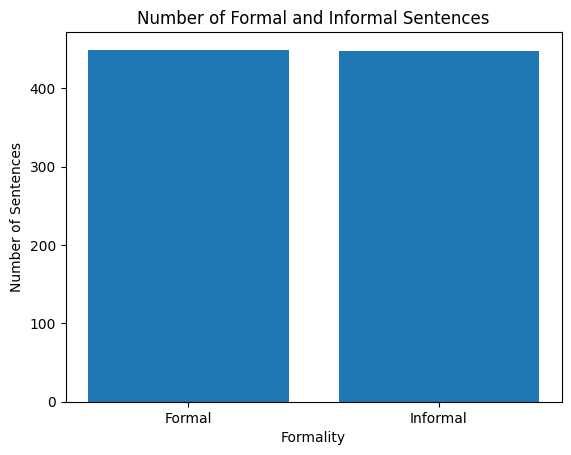

In [3]:
import matplotlib.pyplot as plt
# plot the sum of formal and informal sentences
plt.bar(['Formal', 'Informal'], [binary_df['formal'].sum(), binary_df['formal'].shape[0] - binary_df['formal'].sum()])
plt.xlabel("Formality")
plt.ylabel("Number of Sentences")
plt.title("Number of Formal and Informal Sentences")
plt.show()

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("s-nlp/xlmr_formality_classifier")
model = AutoModelForSequenceClassification.from_pretrained("s-nlp/xlmr_formality_classifier")

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/896 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [5]:
import numpy as np
from tqdm import tqdm

id2formality = {0: "formal", 1: "informal"} # from model documentation on Hugging Face

batch_size = 4
predicted_labels = [] # 0 for informal, 1 for formal (consistent with dataset labels)

for i in tqdm(range(0, len(binary_df), batch_size)):
    texts = binary_df['sentence'][i:i + batch_size].tolist()

    # prepare the input
    encoding = tokenizer(
        texts,
        add_special_tokens=True,
        return_token_type_ids=True,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

    # inference
    output = model(**encoding)

    batch_predicted_labels = []
    for text_scores in output.logits.softmax(dim=1):
        score_dict = {id2formality[idx]: score for idx, score in enumerate(text_scores.tolist())}
        batch_predicted_labels.append(1 if score_dict['formal'] > score_dict['informal'] else 0)

    predicted_labels.extend(batch_predicted_labels)

100%|██████████| 224/224 [13:15<00:00,  3.55s/it]


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(binary_df['formal'], predicted_labels)
accuracy = accuracy_score(binary_df['formal'], predicted_labels)
precision = precision_score(binary_df['formal'], predicted_labels)
recall = recall_score(binary_df['formal'], predicted_labels)
f1 = f1_score(binary_df['formal'], predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[250 197]
 [  6 443]]
Accuracy: 0.7734375
Precision: 0.6921875
Recall: 0.9866369710467706
F1 Score: 0.8135904499540864
